In [1]:
import os
import sys
import torch

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

import domainbed.algorithms as algorithms
from domainbed.lib.fast_data_loader import InfiniteDataLoader, FastDataLoader
from domainbed import datasets
from types import SimpleNamespace
from domainbed.lib import misc


In [2]:
def load_model(model_dir):
    dump = torch.load(os.path.join(model_dir, 'model.pkl'))
    algorithm_class = algorithms.get_algorithm_class(dump["args"]["algorithm"])
    algorithm = algorithm_class(
        dump["model_input_shape"],
        dump["model_num_classes"],
        dump["model_num_domains"],
        dump["model_hparams"])
    algorithm.load_state_dict(dump["model_dict"])
    return algorithm, dump['args'], dump['model_hparams']

def load_dataset(args, hparams):
    args = SimpleNamespace(**args)
    dataset = vars(datasets)[args.dataset](args.data_dir,
                args.test_envs, hparams)
    in_splits = []
    out_splits = []
    uda_splits = []
    val_envs = []
    ## Fill defaults to play nicely with wandb sweeps
    if args.dataset == 'PACS':
        if args.test_envs == None:
            args.test_envs = [0]
        if args.use_densenet == None:
            args.use_densenet = False
    elif args.dataset == 'WILDSCamelyon':
        if args.test_envs == None:
            args.test_envs = [2]
        if args.use_densenet == None:
            args.use_densenet = True
        ## For consistency with wilds benchmark, env 1 should be only used as OOD val dataset
        val_envs.append(1)
    for env_i, env in enumerate(dataset):
        uda = []

        out, in_ = misc.split_dataset(env,
            int(len(env)*args.holdout_fraction),
            misc.seed_hash(args.trial_seed, env_i))

        if env_i in args.test_envs:
            uda, in_ = misc.split_dataset(in_,
                int(len(in_)*args.uda_holdout_fraction),
                misc.seed_hash(args.trial_seed, env_i))

        if hparams['class_balanced']:
            in_weights = misc.make_weights_for_balanced_classes(in_)
            out_weights = misc.make_weights_for_balanced_classes(out)
            if uda is not None:
                uda_weights = misc.make_weights_for_balanced_classes(uda)
        else:
            in_weights, out_weights, uda_weights = None, None, None
        in_splits.append((in_, in_weights))
        out_splits.append((out, out_weights))
        if len(uda):
            uda_splits.append((uda, uda_weights))

    if args.task == "domain_adaptation" and len(uda_splits) == 0:
        raise ValueError("Not enough unlabeled samples for domain adaptation.")

    eval_loaders = [torch.utils.data.DataLoader(
        dataset=env,
        shuffle=False,
        batch_size=64,
        num_workers=4)
        for env, _ in (in_splits + out_splits + uda_splits)]
    eval_weights = [None for _, weights in (in_splits + out_splits + uda_splits)]
    eval_loader_names = ['env{}_in'.format(i)
        for i in range(len(in_splits))]
    eval_loader_names += ['env{}_out'.format(i)
        for i in range(len(out_splits))]
    eval_loader_names += ['env{}_uda'.format(i)
        for i in range(len(uda_splits))]
    loader_dict = {}
    for i in range(len(eval_loaders)):
        loader_dict[eval_loader_names[i]] = eval_loaders[i]
    return loader_dict

    

In [3]:
model, args, hparams = load_model('/network/scratch/o/omar.salemohamed/domainbed/output/3eba208b-5f57-4692-ba7c-fe58be2201a8')
model.eval()

/home/mila/o/omar.salemohamed/.conda/envs/wilds/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/o/omar.salemohamed/.conda/envs/wilds/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DANN(
  (featurizer): DenseNet121(
    (network): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(


In [4]:
loaders = load_dataset(args, hparams)
print(loaders.keys())

dict_keys(['env0_in', 'env1_in', 'env2_in', 'env3_in', 'env4_in', 'env0_out', 'env1_out', 'env2_out', 'env3_out', 'env4_out', 'env0_uda'])


In [5]:
x.shape

NameError: name 'x' is not defined

In [73]:
N = 20
d = 1024
data_shape = (3, 224, 224)
all_features = torch.zeros(5, 2, N, d)
for env_id in range(5):
    loader = loaders[f'env{env_id}_out']
    for x, y in loader:
        features = model.featurizer(x)
        for label in [0, 1]:
            all_features[env_id, label] = features[y==label][:N].detach().cpu()
        break
            


In [74]:
all_features.shape

torch.Size([5, 2, 20, 1024])

In [76]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
pca = PCA()
pca_feats = pca.fit_transform(all_features.flatten(end_dim=-2))
pca_feats = pca_feats.reshape(5, 2, N, pca_feats.shape[-1])
pca_feats = pca_feats[:, :, :, :2]
print(pca_feats.shape)
df_data = []
for env_id in range(5):
    for label in [0, 1]:
        for n in range(N):
            df_data.append([env_id, label, n, pca_feats[env_id, label, n, 0], pca_feats[env_id, label, n, 1]])
df = pd.DataFrame(df_data, columns = ['env', 'class', 'n', 'pc_0', 'pc_1'])


(5, 2, 20, 2)


<Axes: xlabel='pc_0', ylabel='pc_1'>

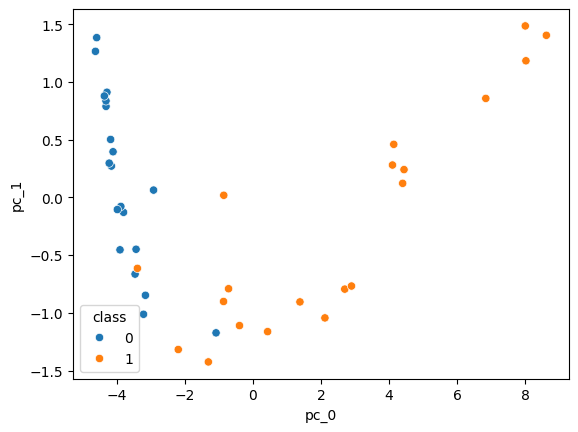

In [89]:
import seaborn as sns
sns.scatterplot(data=df.query('env==1'), x='pc_0', y='pc_1', hue='class')

In [42]:
for x, y in loaders['env2_out']:
    features = model.featurizer(x)
    print(features.shape)
    break

torch.Size([64, 1024])


In [ ]:
for x, y in loaders['env2_out']:
    preds = model.predict(x)
    acc = (preds.argmax(dim=1) == y).float().mean().item()
    print(acc)
    break